<a href="https://colab.research.google.com/github/paolobalasso/TradingStrategy/blob/master/portfolio_optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
####  install package ####

!pip install pyPortfolioOpt
!pip install pyfolio
!pip install yahoofinancials
!pip install -q gwpy

#### Import packages

import pandas as pd 
import numpy as np 
import datetime 
import math 
from tabulate import tabulate 
import matplotlib.pyplot as plt 
import seaborn as sns 
import cvxopt as opt 
from cvxopt import blas, solvers 
import cvxpy as cp
import pyfolio as pf
import pypfopt as py
from yahoofinancials import YahooFinancials
import numpy as np
import pandas_datareader as web

     |████████████████████████████████| 51kB 4.3MB/s 
     |████████████████████████████████| 92kB 6.2MB/s 
     |████████████████████████████████| 61kB 7.1MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-cp36-none-any.whl size=88669 sha256=80b7f24e0d954a68bcab3a220bcda74805c1c7f8e43fe9e910dd71e53e5a9123
  Stored in directory: /root/.cache/pip/wheels/0d/a8/7d/ac33fe6bf6f3db370291c9de303460d00b8f97cc40a1d80f72
  Created wheel for empyrical: filename=empyrical-0.5.5-cp36-none-any.whl size=39765 sha256=611a4f3a39560fadb0382edfb06583ebc428936053deac685d2f85f7d6cea51f
  Stored in directory: /root/.cache/pip/wheels/ea/b2/c8/6769d8444d2f2e608fae2641833110668d0ffd1abeb2e9f3fc
Successfully built pyfolio empyrical
  Created wheel for yahoofinancials: filename=yahoofinancials-1.6-cp36-none-any.whl size=15192 sha256=08510d765e374457b7020a929b2e7b48cf2360a42686878d7ae26eafd4eb1703
  Stored in directory: /root/.cache/pip/wheels/d9/7e/cf/4977a8572d5247242a4b13018d1d36923024ba84236e0d28bc
Suc

/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


##Investing on stock ETFs##

The following code takes into consideration the US stock index and the World stock index evaluating their return distribution. The investiment strategy considers a buy and hold strategy during a time spans of 5, 10, 30 years.
All these data are in dollars, thus if the investor lives in an European Country or in another country, the currency exchange must be considered.

In order to select an ETF we have to consider several aspects:


* Market Size

* Acquisition Cost

* Total Cost of Ownership

* Coverage for Exchange Rate - Headged / Unhedged etfs

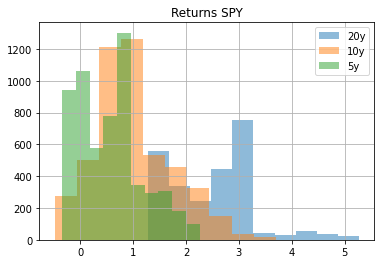

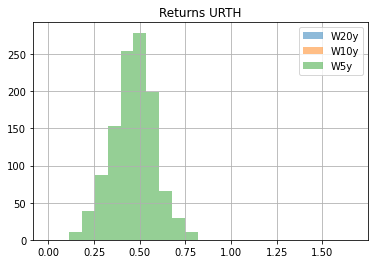

In [7]:
#### sample analysis

SPY_df = web.DataReader('SPY','yahoo','1970-01-01','2020-12-31')['Adj Close']
(SPY_df.pct_change(225*20)).hist(label='20y',alpha= .5)
(SPY_df.pct_change(225*10)).hist(label='10y',alpha= .5)
(SPY_df.pct_change(225*5)).hist(label='5y',alpha= .5)
plt.legend()
plt.title('Returns SPY')
plt.show()

SPY_df = web.DataReader('URTH','yahoo','1970-01-01','2020-12-31')['Adj Close']
(SPY_df.pct_change(225*20)).hist(label='W20y',alpha= .5)
(SPY_df.pct_change(225*10)).hist(label='W10y',alpha= .5)
(SPY_df.pct_change(225*5)).hist(label='W5y',alpha= .5)
plt.legend()
plt.title('Returns URTH')
plt.show()

##Hedged vs Unhedged ETFs##

Currency hedging can help reduce the effect of exchange rate fluctuations on international investments.  If you invest in international ETFs, choosing a fund that uses hedging can help to protect you against the downside of currency fluctuations, but it also means you may not benefit from situations in which a currency fluctuation would have actually been a good thing for your investment. Choosing an unhedged ETF can allow you to gain from beneficial currency changes, but you also carry the risk of the negative effects of currency price changes.

In the next plot you can see the correlation between the EURO/Dollar exchange rate and the difference between two ETF related to the same MSCI world etf:
IWDE.MI (Hedged) and SWDA.MI (unHedged)

In [ ]:
(web.DataReader(['IWDE.MI','SWDA.MI'],'yahoo','2019-01-01','2020-12-31')['Adj Close'].pct_change()+1).cumprod().plot()
plt.title('Hedge WI Found vsWI found')
plt.show()

web.DataReader(['EURUSD=X'],'yahoo','2019-01-01','2020-12-31')['Adj Close'].plot()
plt.title('Euro - dollar exchange rate')
plt.show()

In [7]:
#### Import ETF list

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#read in ETF listing
ETF_df = pd.read_csv('/content/drive/My Drive/prova/AllTypes.csv',sep=';', encoding= 'unicode_escape')
US_ETF = ETF_df.loc[ETF_df.country== 'US Equity ETF']
WRLD_ETF = ETF_df.loc[ETF_df.country== 'Global Equity ETF']
US_cap_df = pd.read_csv('/content/drive/My Drive/prova/US_ETF_CAP.csv',sep=';', encoding= 'unicode_escape')
WORLD_cap_df = pd.read_csv('/content/drive/My Drive/prova/WORLD_ETF_CAP.csv',sep=';', encoding= 'unicode_escape')
US_ETF_df = pd.read_csv('/content/drive/My Drive/prova/US_ETF_df.csv',sep=';', encoding= 'unicode_escape')
WRLD_ETF_df = pd.read_csv('/content/drive/My Drive/prova/WRLD_ETF_df.csv',sep=';', encoding= 'unicode_escape')

US_ETF_df= US_ETF_df.set_index(pd.DatetimeIndex(US_ETF_df['Date'])).drop(['Date'],axis=1)
WRLD_ETF_df = WRLD_ETF_df.set_index(pd.DatetimeIndex(WRLD_ETF_df['Date'])).drop(['Date'],axis=1)

US_ETF_to_take = US_cap_df.loc[US_cap_df.iloc[:,1].values>700000000,:].iloc[:,0].values
WRLD_ETF_to_take = WORLD_cap_df.loc[WORLD_cap_df.iloc[:,1].values>700000000,:].iloc[:,0]


Mounted at /content/drive


In [ ]:
#### all data download if you want to refresh the data ####

yahoo_financials_tech = YahooFinancials(US_ETF.Sym.values)
cap = yahoo_financials_tech.get_market_cap()
US_cap_df = pd.DataFrame.from_dict(cap, orient='index', dtype=None, columns=None)

yahoo_financials_tech = YahooFinancials(WRLD_ETF.Sym.values)
cap = yahoo_financials_tech.get_market_cap()
WORLD_cap_df = pd.DataFrame.from_dict(cap, orient='index', dtype=None, columns=None)


US_cap_df.to_csv('/content/drive/My Drive/prova/US_ETF_CAP.csv',sep=';')
WORLD_cap_df.to_csv('/content/drive/My Drive/prova/WORLD_ETF_CAP.csv',sep=';')

US_ETF_to_take = US_cap_df.loc[US_cap_df.iloc[:,1].values>700000000,:].iloc[:,0].values
WRLD_ETF_to_take = WORLD_cap_df.loc[WORLD_cap_df.iloc[:,1].values>700000000,:].iloc[:,0]

US_ETF_df = web.DataReader(US_ETF_to_take,'yahoo','2012-01-01','2020-12-31')['Adj Close']
WRLD_ETF_df = web.DataReader(WRLD_ETF_to_take,'yahoo','2012-01-01','2020-12-31')['Adj Close']

US_ETF_df.to_csv('/content/drive/My Drive/prova/US_ETF_df.csv',sep=';')
WRLD_ETF_df.to_csv('/content/drive/My Drive/prova/WRLD_ETF_df.csv',sep=';')


## Balanced and unbalanced portfolio ##

In the next section we will explore the cost between a yearly balanced dataset and a buy-long portfolio strategy. We will figure out the benefit of balancing a portfolio considering the percentage return and at the same time the volatility metrics and on the other and the cost derived by this approach.

We know that the future value of a certain investment $I$ after $n$ years with a return of $i$ is:

>$FV = I (1+(i))^n $

Assuming that we will change stock each year, so at the end of the year we will sell the position and buy another one we will have:

* The cost of acquisition
* The tax on the plusvalence that in Italy are $26\%$, the annual total cost of ownership.

Considering that the second factor gains the main effect we have that for the yearly balanced strategy we have the following equation:

>$FV_{balanced} = I * (1+(i*0.73))^n $

The return of the balanced strategy will be the following one:

>$Return\%_{balanced} = \frac{I * (1+ i*0.73)^n -I}{I} = (1+ i*0.73)^n - 1$ 


For the first strategy the future value and the percentage return will be:

>$FV_{unbalanced} = I * (1+i)^n $

>$Return\%_{unbalanced} = \frac{I * (1+ i)^n -I}{I} = (1+ i)^n - 1$ 


If we consider the difference of the return in percentage points between the first and the second strategy we have the following equation:

>$(1+x)^n - 1 - ((1+x*0.73)^n - 1)=$

>=$(1+x)^n - (1+x*0.73)^n$

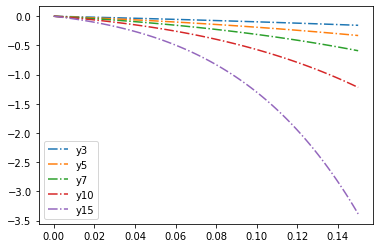

In [4]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0,0.15,100)

y3 = ((1+x*0.73)**3)-(1+x)**3
y5 = ((1+x*0.73)**5)-(1+x)**5
y7 = ((1+x*0.73)**7)-(1+x)**7
y10 = ((1+x*0.73)**10) -(1+x)**10
y20 = ((1+x*0.73)**15) -(1+x)**15

# setting the axes at the centre
fig = plt.figure()

# plot the function
plt.plot(x,y3,'-.',label='y3')
plt.plot(x,y5,'-.',label='y5')
plt.plot(x,y7,'-.',label='y7')
plt.plot(x,y10,'-.',label='y10')
plt.plot(x,y20,'-.',label='y15')
plt.legend()
plt.show()

## Balance and Unbalance portfolio strategy in a yearly frequency deposit

In the this part we will consider the cost between a yearly balanced dataset strategy. We know that the future value of a certain investment every year with an amount equal of $I$  after  $n$  years with a return of  $i$  is:

$FV=I*\frac{(1 + i)^n - 1}{i} $

Considering a balance strategy each year, thus shorting all position and going long on another position the equation is this one:

$FV=I*\frac{(1 + i*0.73)^{n+1} - 1}{i*0.73}$

The difference in percentage points beetween the return of these two strategy will be:

$\frac{(1 + i*0.73)^{n+1} - 1}{i*0.73} -1 - (\frac{(1 + i)^{n+1} - 1}{i} - 1)$

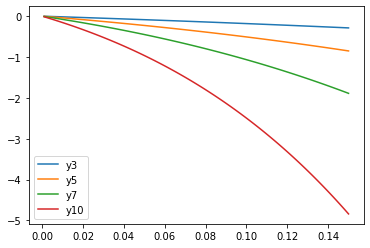

In [15]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(0.001,0.15,100)

y3 = (((1+x*0.73)**4)-1)/(x*0.73) - (((1+x)**4)-1)/(x)
y5 = (((1+x*0.73)**6)-1)/(x*0.73) - (((1+x)**6)-1)/(x)
y7 = (((1+x*0.73)**8)-1)/(x*0.73) - (((1+x)**8)-1)/(x)
y10 = (((1+x*0.73)**11)-1)/(x*0.73) - (((1+x)**11)-1)/(x)
y20 = (((1+x*0.73)**16)-1)/(x*0.73) - (((1+x)**16)-1)/(x)

# setting the axes at the centre
fig = plt.figure()

# plot the function
plt.plot(x,y3,label='y3')
plt.plot(x,y5,label='y5')
plt.plot(x,y7,label='y7')
plt.plot(x,y10,label='y10')
plt.legend()
plt.show()

Putting all these strategy altogether to compare them we have the following table:

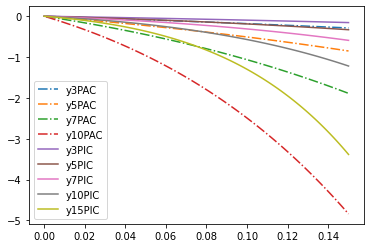

In [16]:
fig = plt.figure()

# plot the function
plt.plot(x,y3,'-.',label='y3PAC')
plt.plot(x,y5,'-.',label='y5PAC')
plt.plot(x,y7,'-.',label='y7PAC')
plt.plot(x,y10,'-.',label='y10PAC')

x = np.linspace(0,0.15,100)
y3 = ((1+x*0.73)**3)-(1+x)**3
y5 = ((1+x*0.73)**5)-(1+x)**5
y7 = ((1+x*0.73)**7)-(1+x)**7
y10 = ((1+x*0.73)**10) -(1+x)**10
y20 = ((1+x*0.73)**15) -(1+x)**15

# plot the function
plt.plot(x,y3,label='y3PIC')
plt.plot(x,y5,label='y5PIC')
plt.plot(x,y7,label='y7PIC')
plt.plot(x,y10,label='y10PIC')
plt.plot(x,y20,label='y15PIC')
plt.legend()
plt.show()

In [14]:
# import necessary libraries 

%matplotlib inline
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')
import pandas_datareader.data as web
from datetime import datetime

def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns
  
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record


def value_at_risk(x, lab_return='ret', confidence_level=.05):
    return x[lab_return].quantile(confidence_level, interpolation='higher')

def expected_shortfall(x, lab_return='ret', confidence_level=.05):
    var = value_at_risk(x, lab_return, confidence_level)
    return x[lab_return][x[lab_return].lt(var)].mean()

def volatility(x, lab_return='ret'):
    return x[lab_return].std()

def Sharpe_Ratio(x,lab_return='ret',rf=0):
    mean_avg_daily_rets = (x[lab_return] - rf).mean()
    vol = volatility(x,lab_return=lab_return)
    sharpe_ratio = (mean_avg_daily_rets/vol)
    return sharpe_ratio

def sortino_ratio(x,lab_return='ret',rf=0):
    expected_return = x[lab_return].mean()
    down_stdev = x.loc[x[lab_return] < 0, lab_return].dropna().std()
    sortino_ratio = (expected_return - rf)/down_stdev
    return sortino_ratio

def stamptodate(x): 
    from datetime import datetime
    import numpy as np
    ts = (x - np.datetime64('1970-01-01T00:00:00Z')) / np.timedelta64(1, 's')
    return datetime.utcfromtimestamp(ts)

def average_year_return(x,lab_return='ret'):
    start_date = stamptodate(min(x[lab_return].index))
    end_date = stamptodate(max(x[lab_return].index))
    difference_in_years = (end_date.year - start_date.year)/220
    return (x[lab_return].dropna()+1).cumprod().tail(1)**(1/difference_in_years)-1

def average_year_return2(x,lab_return='ret',end_date  =datetime(2019,6,30), start_date=datetime(2018,6,30)):
    difference_in_years = (end_date - start_date).days/220
    return (x[lab_return].dropna()+1).cumprod().tail(1)**(1/difference_in_years)-1

def average_year_return3(x,lab_return='ret',end_date  =datetime(2019,6,30), start_date=datetime(2018,6,30)):
    difference_in_years = len(x)/220
    return (x[lab_return].dropna()+1).cumprod().tail(1)**(1/difference_in_years)-1

def final_return(x, lab_return='ret'):
  return (x[lab_return].dropna()+1).cumprod().tail(1).values-1

def drawdown(equity):
    """
    Funzione che calcola il draw down data un'equity line
    """
    maxvalue = equity.expanding(0).max()
    drawdown = equity - maxvalue
    drawdown_series = pd.Series(drawdown, index = equity.index)
    return drawdown_series

def plot_drawdown(equity,color):
    """
    Funzione per graficare la curva di draw down
    """
    dd = drawdown(equity)
    #plt.figure(figsize = (12, 6), dpi = 300)
    plt.plot(dd, color = color)
    plt.fill_between(dd.index, 0, dd, color = color)
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Draw Down')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def plot_double_equity(closed_equity,open_equity):
    """
    Funzione per stampare due equity sovrapposte
    """
    plt.figure(figsize=(14, 8), dpi=300)
    plt.plot(open_equity, color='red')
    plt.plot(closed_equity, color='green')
    plt.xlabel("Time")
    plt.ylabel("Profit/Loss")
    plt.title('Open & Closed Equity Line')
    plt.xticks(rotation='vertical')
    plt.grid(True)
    plt.show()
    return
    
def profit(equity):
    return round(equity[-1],2)

def profit1(operations):
    return round(operations.sum(),2)
    
def operation_number(operations):
    return operations.count()
    
def avg_trade(operations):
    return round(operations.mean(),2)
    
def max_draw_down(equity):
    dd = drawdown(equity)
    return round(dd.min(),2)
    
def avgdrawdown_nozero(equity):
    """
    calcola la media del draw down storico
    non considerando i valori nulli (nuovi massimi di equity line)
    """
    dd = drawdown(equity)
    return round(dd[dd < 0].mean(),2)

#Create a function to signal when to buy and sell an asset
def buy_sell(signal,symbol):
  sigPriceBuy = []
  sigPriceSell = []
  flag = -1
  for i in range(0,len(signal)):
    #if sma30 > sma100  then buy else sell
      if signal['SMA30'][i] > signal['SMA100'][i]:
        if flag != 1:
          sigPriceBuy.append(signal[symbol][i])
          sigPriceSell.append(np.nan)
          flag = 1
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
        #print('Buy')
      elif signal['SMA30'][i] < signal[symbol][i]:
        if flag != 0:
          sigPriceSell.append(signal[symbol][i])
          sigPriceBuy.append(np.nan)
          flag = 0
        else:
          sigPriceBuy.append(np.nan)
          sigPriceSell.append(np.nan)
        #print('sell')
      else: #Handling nan values
        sigPriceBuy.append(np.nan)
        sigPriceSell.append(np.nan)
  
  return (sigPriceBuy, sigPriceSell)



def MovingAverageCrossStrategy(stock_symbol = 'ULTRACEMCO.NS', start_date = '2018-01-01', end_date = '2020-01-01', 
                               short_window = 20, long_window = 50, moving_avg = 'SMA', display_table = True):
    '''
    The function takes the stock symbol, time-duration of analysis, 
    look-back periods and the moving-average type(SMA or EMA) as input 
    and returns the respective MA Crossover chart along with the buy/sell signals for the given period.
    '''
    # stock_symbol - (str)stock ticker as on Yahoo finance. Eg: 'ULTRACEMCO.NS' 
    # start_date - (str)start analysis from this date (format: 'YYYY-MM-DD') Eg: '2018-01-01'
    # end_date - (str)end analysis on this date (format: 'YYYY-MM-DD') Eg: '2020-01-01'
    # short_window - (int)lookback period for short-term moving average. Eg: 5, 10, 20 
    # long_window - (int)lookback period for long-term moving average. Eg: 50, 100, 200
    # moving_avg - (str)the type of moving average to use ('SMA' or 'EMA')
    # display_table - (bool)whether to display the date and price table at buy/sell positions(True/False)

    # import the closing price data of the stock for the aforementioned period of time in Pandas dataframe
    start = datetime.datetime(*map(int, start_date.split('-')))
    end = datetime.datetime(*map(int, end_date.split('-'))) 
    stock_df = web.DataReader(stock_symbol, 'yahoo', start = start, end = end)['Close']
    stock_df = pd.DataFrame(stock_df) # convert Series object to dataframe 
    stock_df.columns = {'Close Price'} # assign new colun name
    stock_df.dropna(axis = 0, inplace = True) # remove any null rows 
                        
    # column names for long and short moving average columns
    short_window_col = str(short_window) + '_' + moving_avg
    long_window_col = str(long_window) + '_' + moving_avg  
  
    if moving_avg == 'SMA':
        # Create a short simple moving average column
        stock_df[short_window_col] = stock_df['Close Price'].rolling(window = short_window, min_periods = 1).mean()

        # Create a long simple moving average column
        stock_df[long_window_col] = stock_df['Close Price'].rolling(window = long_window, min_periods = 1).mean()

    elif moving_avg == 'EMA':
        # Create short exponential moving average column
        stock_df[short_window_col] = stock_df['Close Price'].ewm(span = short_window, adjust = False).mean()

        # Create a long exponential moving average column
        stock_df[long_window_col] = stock_df['Close Price'].ewm(span = long_window, adjust = False).mean()

    # create a new column 'Signal' such that if faster moving average is greater than slower moving average 
    # then set Signal as 1 else 0.
    stock_df['Signal'] = 0.0  
    stock_df['Signal'] = np.where(stock_df[short_window_col] > stock_df[long_window_col], 1.0, 0.0) 

    # create a new column 'Position' which is a day-to-day difference of the 'Signal' column. 
    stock_df['Position'] = stock_df['Signal'].diff()

    # plot close price, short-term and long-term moving averages
    plt.figure(figsize = (20,10))
    plt.tick_params(axis = 'both', labelsize = 14)
    stock_df['Close Price'].plot(color = 'k', lw = 1, label = 'Close Price')  
    stock_df[short_window_col].plot(color = 'b', lw = 1, label = short_window_col)
    stock_df[long_window_col].plot(color = 'g', lw = 1, label = long_window_col) 

    # plot 'buy' signals
    plt.plot(stock_df[stock_df['Position'] == 1].index, 
            stock_df[short_window_col][stock_df['Position'] == 1], 
            '^', markersize = 15, color = 'g', alpha = 0.7, label = 'buy')

    # plot 'sell' signals
    plt.plot(stock_df[stock_df['Position'] == -1].index, 
            stock_df[short_window_col][stock_df['Position'] == -1], 
            'v', markersize = 15, color = 'r', alpha = 0.7, label = 'sell')
    plt.ylabel('Price in ₹', fontsize = 16 )
    plt.xlabel('Date', fontsize = 16 )
    plt.title(str(stock_symbol) + ' - ' + str(moving_avg) + ' Crossover', fontsize = 20)
    plt.legend()
    plt.grid()
    plt.show()
    
    if display_table == True:
        df_pos = stock_df[(stock_df['Position'] == 1) | (stock_df['Position'] == -1)]
        df_pos['Position'] = df_pos['Position'].apply(lambda x: 'Buy' if x == 1 else 'Sell')
        print(tabulate(df_pos, headers = 'keys', tablefmt = 'psql'))

#### portfolio simulation function ####

def portfolio_dynamic_optimization(df , training_months = 48, change_freq=1,strategy='vol',lab='stock',startperiod='2015-12-31'):
  #### Import libraries ####
  import pandas as pd
  import pandas as pd
  from pypfopt import EfficientFrontier
  from pypfopt import risk_models
  from pypfopt import expected_returns
  import pandas_datareader as web
  from datetime import datetime
  from dateutil.relativedelta import relativedelta

  # future stock allocation
  datalist = pd.date_range(startperiod,'2021-12-01', freq=str(change_freq)+'Y').strftime("%Y-%m-%d").tolist()

  #stock to consider
  
  returns = df.pct_change().fillna(0)


  # initialize allocation and return dfs
  allocationdf = pd.DataFrame(index=df.columns)
  allocationdfsym = pd.DataFrame(index=df.columns)
  returndf = pd.DataFrame()



  for j,i in enumerate(datalist):

    dt = datetime.strptime(i, '%Y-%m-%d')
    test_data = dt - relativedelta(months=training_months)
    val_data = dt + relativedelta(months=change_freq*12)
    

    window_df = df.loc[(df.index>=test_data) & (df.index<=i)].dropna(axis=1,how="all")
    mu = expected_returns.mean_historical_return(window_df,frequency=252)
    S = risk_models.sample_cov(window_df)
    
    # Optimise for maximal Sharpe ratio

    ef = EfficientFrontier(mu, S)
    if strategy =='vol':
      raw_weights_s = ef.min_volatility()
    else:
      raw_weights_s = ef.max_sharpe()
    cleaned_weights_s = ef.clean_weights()

    
    #### append windows data
    weight_window = pd.DataFrame.from_dict(cleaned_weights_s,orient='index',columns=[i])
    allocationdfsym = allocationdf = pd.concat([allocationdf,weight_window],axis=1).fillna(0)
    return_window = (allocationdf[i].values.reshape(1,len(df.columns))*returns.loc[(df.index>=i) & (df.index<val_data)]).sum(axis=1).to_frame(name='ret')
    returndf = returndf.append(return_window, ignore_index=False)

  label= str(lab) + '_' + str(training_months) + '_' + str(change_freq) + '_' + str(strategy)
  kpis_array = np.array([label,
        np.around(float(returndf['ret'].mean()),4),
        np.around(float(average_year_return3(returndf,lab_return='ret')),4),
        np.around(float(final_return(returndf,lab_return='ret')),4),
        np.around(float(returndf['ret'].min()),4),
        np.around(float(volatility(returndf,lab_return='ret')),4),
        np.around(max_draw_down((1+returndf.ret).cumprod()-1),4),
        np.around(avgdrawdown_nozero((1+returndf.ret).cumprod()-1),4),
        np.around(float(Sharpe_Ratio(returndf,lab_return='ret')),4),
        np.around(float(sortino_ratio(returndf,lab_return='ret')),4),
        np.around(float(value_at_risk(returndf,lab_return='ret')),4),
        np.around(float(expected_shortfall(x=returndf, lab_return='ret' , confidence_level=.05)),4),
        np.around(float(len(returndf['ret'].dropna()))),
        np.around(float(final_return(returndf,lab_return='ret'))/abs(max_draw_down((1+returndf.ret).cumprod()-1)) ,4)]
        )


  kpis = pd.DataFrame(kpis_array.flatten().reshape(1,14),
                    columns= ['label','av_return','Yearly_returns','final_return','min','Volatility','maxdrow','avdrow','Sharpe_ratio','Sortino_Ratio','VAR','ES','no_operations','RR'])
 
  
  
  print(label)
  plot_drawdown((1+returndf.ret).cumprod()-1,color='red')


  #### returns ####
  (returndf+1).cumprod().plot(label='simul')
  plt.legend(labelspacing=0.8)
  plt.show()
  

  #### composition
  allocationdf = allocationdf.T.loc[:, (allocationdf.T != 0).any(axis=0)]
  allocationdfsym = allocationdfsym.T.loc[:, (allocationdfsym.T != 0).any(axis=0)]
  try:
    allocationdf.columns = ETF_df.loc[np.isin(ETF_df.Sym.values,allocationdf.columns.values)]['Description'].values
  except:
    allocationdf.columns = allocationdf.columns.values
  allocationdf.plot.bar(stacked=True)
  plt.show()

                        #,  figsize=(10,7))
 
 
  return kpis, returndf, allocationdf, allocationdfsym

In [11]:

#df = US_ETF_df.loc[:,np.isin(US_ETF_df.columns,US_ETF_to_take)]
#dfu = df.append(web.DataReader(US_ETF_to_take,'yahoo','2020-11-29','2021-12-31')['Adj Close'])

df = WRLD_ETF_df.loc[:,np.isin(WRLD_ETF_df.columns,WRLD_ETF_to_take)]
dfw = df.append(web.DataReader(WRLD_ETF_to_take,'yahoo','2020-11-29','2021-12-31')['Adj Close'])

dfm = web.DataReader(['IWMO.MI','IWDE.MI','GLD','EM710.MI'],'yahoo','2012-01-01','2020-12-31')['Adj Close']

dfm2 = web.DataReader(['EM710.MI','IWDE.MI','GLD','JMBE.MI'],'yahoo','2012-01-01','2020-12-31')['Adj Close']


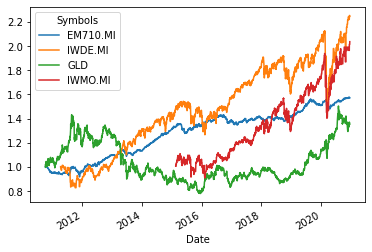

In [23]:
m = web.DataReader(['EM710.MI','IWDE.MI','GLD','IWMO.MI'],'yahoo','2012-01-01','2020-12-31')['Close']
(web.DataReader(['EM710.MI','IWDE.MI','GLD','IWMO.MI'],'yahoo','2010-10-01','2020-12-31')['Close'].pct_change()+1).cumprod().plot()



In [ ]:

#!pip install ffn
#import ffn
#web.DataReader(['SPYXE'],'yahoo','2015-01-01','2020-12-31')['Adj Close'].plot()
#yahoo_financials_tech.get_market_cap()
#web.get_data_yahoo('SPY', '2015-01-01','2020-12-31')
#!pip install yfinance
import yfinance as yf
!pip install Yahoo-ticker-downloader

msft = yf.Ticker("IUSE")
msft.history(period="max")

In [ ]:
#### find optimal solution ####



df = pd.DataFrame()
allocationdf = pd.DataFrame(columns=np.unique(np.concatenate((dfm2.columns.values,dfm.columns.values,dfw.columns.values))))
returndf = pd.DataFrame()

for c,i in enumerate([dfm,dfm2,dfw], 0):
  lab = ['M','M2','W'][c]
  for t in [12,24,36]:
    for s in ['vol','sharpe']:
      label=str(lab)+str(t)+str(s)
      print(label)

      try:
        kpis, U_returndf, U_allocationdf, U_allocationdfsym = portfolio_dynamic_optimization(df = i, training_months = t, change_freq=1,strategy=s,lab= lab)
        df = df.append(kpis,ignore_index=True)
       
        U_allocationdfsym['label'] = label
        U_returndf['label'] = label
        allocationdf = allocationdf.append(U_allocationdfsym)
        returndf = returndf.append(U_returndf,ignore_index=False)
      except:
        print('out')

In [ ]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
df
(df.sort_values('RR'))

#allocationdf.dropna(axis=1,how='all')

,label,av_return,Yearly_returns,final_return,min,Volatility,maxdrow,avdrow,Sharpe_ratio,Sortino_Ratio,VAR,ES,no_operations,RR
11,M2_36_1_sharpe,0.0002,0.0411,0.2637,-0.0789,0.0062,-0.31,-0.04,0.0327,0.0335,-0.0079,-0.0151,1278.0,0.8505
9,M2_24_1_sharpe,0.0002,0.0423,0.2724,-0.0662,0.0059,-0.27,-0.04,0.0351,0.0379,-0.0079,-0.0143,1278.0,1.0089
14,W_12_1_vol,0.0004,0.0781,0.5323,-0.0989,0.0091,-0.46,-0.05,0.0422,0.045,-0.0114,-0.0217,1249.0,1.1571
13,M2_48_1_sharpe,0.0003,0.0609,0.4097,-0.0805,0.0061,-0.35,-0.03,0.0473,0.0476,-0.006,-0.0143,1278.0,1.1707
17,W_36_1_vol,0.0004,0.08,0.5479,-0.0959,0.0092,-0.46,-0.05,0.0428,0.0463,-0.0115,-0.022,1249.0,1.1912
19,W_48_1_vol,0.0004,0.0788,0.5378,-0.096,0.0091,-0.45,-0.05,0.0423,0.0457,-0.0116,-0.022,1249.0,1.1952
15,W_24_1_vol,0.0004,0.0837,0.5784,-0.096,0.0091,-0.47,-0.05,0.0449,0.0486,-0.011,-0.0216,1249.0,1.2305
16,W_24_1_sharpe,0.0005,0.0919,0.6472,-0.1028,0.0123,-0.47,-0.1,0.0386,0.0473,-0.0179,-0.0297,1249.0,1.3771
7,M2_12_1_vol,0.0001,0.031,0.1939,-0.0381,0.0031,-0.14,-0.02,0.0461,0.0496,-0.0041,-0.0072,1278.0,1.385
12,M2_48_1_vol,0.0002,0.0357,0.2258,-0.035,0.0028,-0.14,-0.02,0.0577,0.0612,-0.0035,-0.0064,1278.0,1.6132


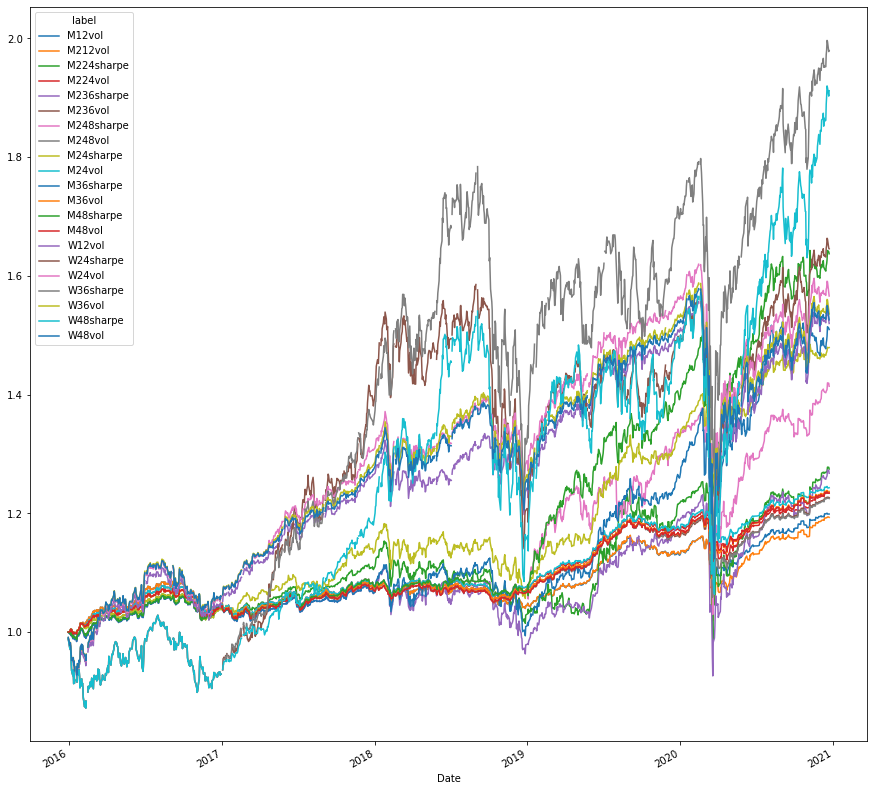

In [ ]:
(returndf.pivot(columns='label', values='ret')+1).cumprod().plot(figsize=(15,15))

In [ ]:
#### buy & sell ####

import datetime

for i in allocationdf.loc['2020-12-31'].dropna(how='all').columns.values:
  print(str(i) + '-' + str(ETF_df.loc[np.isin(ETF_df.Sym.values,i)].Description))
  MovingAverageCrossStrategy(stock_symbol = i,start_date = '2018-01-01', end_date = '2020-12-01', short_window = 30, long_window = 100, moving_avg = 'EMA', display_table = True)


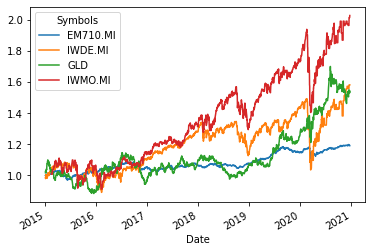

In [5]:
m = web.DataReader(['EM710.MI','IWMO.MI','IWDE.MI'],'yahoo','2012-01-01','2020-12-31')['Close']
(web.DataReader(['EM710.MI','IWDE.MI','GLD','IWMO.MI'],'yahoo','2015-01-01','2020-12-31')['Close'].pct_change()+1).cumprod().plot()



stock_24_3_sharpe


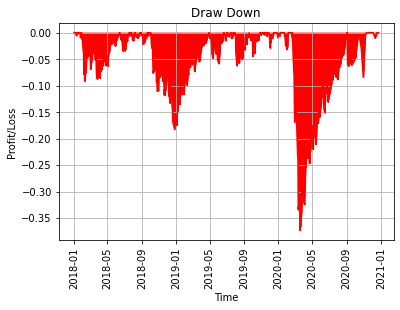

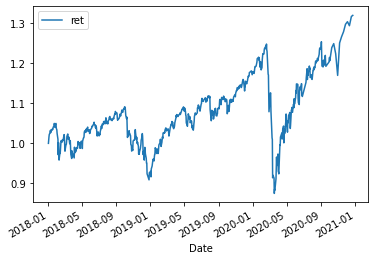

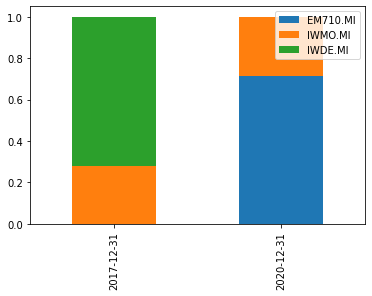

stock_24_2_sharpe


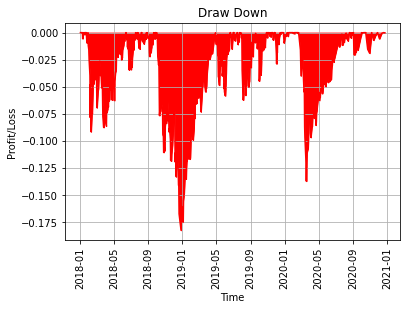

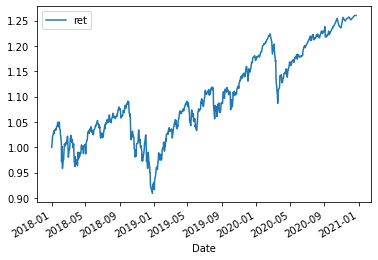

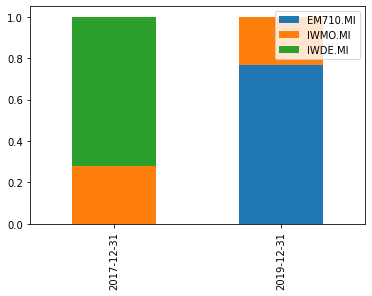

In [10]:
kps1, my_returndf1, my_allocationdf1, allocationdfsym1 = portfolio_dynamic_optimization(df = m, training_months = 24, change_freq=3, strategy='sharpe',startperiod='2017-12-31')
kps2, my_returndf2, my_allocationdf2, allocationdfsym2 = portfolio_dynamic_optimization(df = m, training_months = 24, change_freq=2, strategy='sharpe',startperiod='2017-12-31')

In [11]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.concat([kps1,kps2])

,label,av_return,Yearly_returns,final_return,min,Volatility,maxdrow,avdrow,Sharpe_ratio,Sortino_Ratio,VAR,ES,no_operations,RR
0,stock_24_3_sharpe,0.0005,0.0929,0.3197,-0.0949,0.0121,-0.37,-0.06,0.0394,0.0439,-0.0193,-0.0316,687.0,0.864
0,stock_24_2_sharpe,0.0004,0.0769,0.2605,-0.0385,0.0077,-0.18,-0.04,0.0476,0.0562,-0.014,-0.0202,687.0,1.447


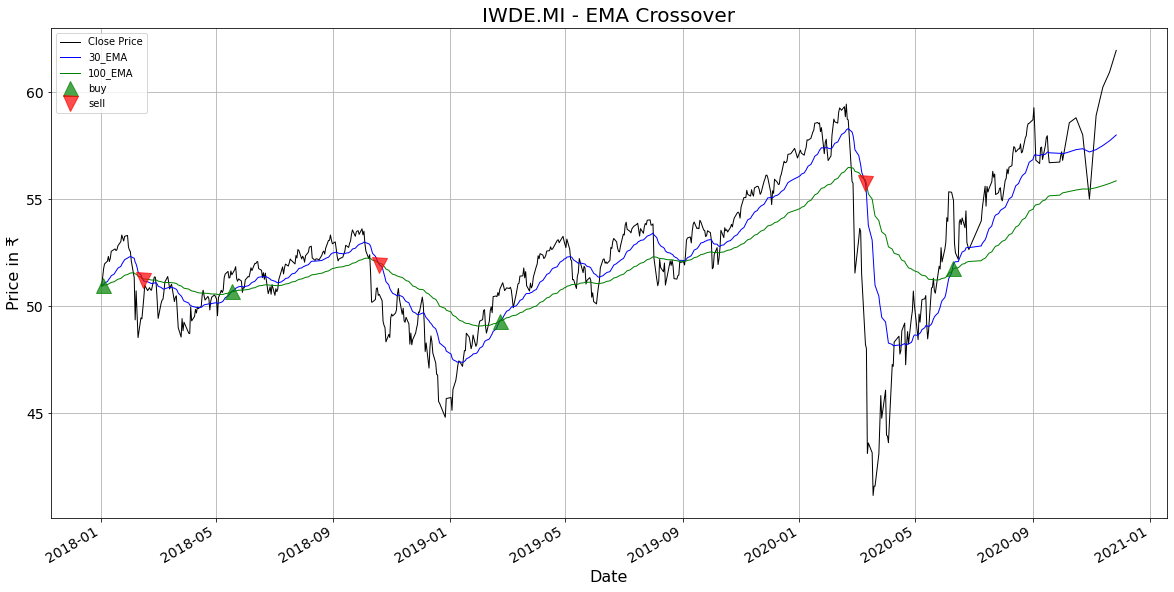

+---------------------+---------------+----------+-----------+----------+------------+
| Date                |   Close Price |   30_EMA |   100_EMA |   Signal | Position   |
|---------------------+---------------+----------+-----------+----------+------------|
| 2018-01-03 00:00:00 |        51.35  |  50.9758 |   50.9579 |        1 | Buy        |
| 2018-02-14 00:00:00 |        49.89  |  51.2414 |   51.2963 |        0 | Sell       |
| 2018-05-18 00:00:00 |        51.47  |  50.7032 |   50.6748 |        1 | Buy        |
| 2018-10-19 00:00:00 |        50.56  |  51.948  |   52.0086 |        0 | Sell       |
| 2019-02-22 00:00:00 |        50.8   |  49.3235 |   49.3098 |        1 | Buy        |
| 2020-03-10 00:00:00 |        48.215 |  55.7614 |   55.8933 |        0 | Sell       |
| 2020-06-09 00:00:00 |        55.14  |  51.7871 |   51.6864 |        1 | Buy        |
+---------------------+---------------+----------+-----------+----------+------------+


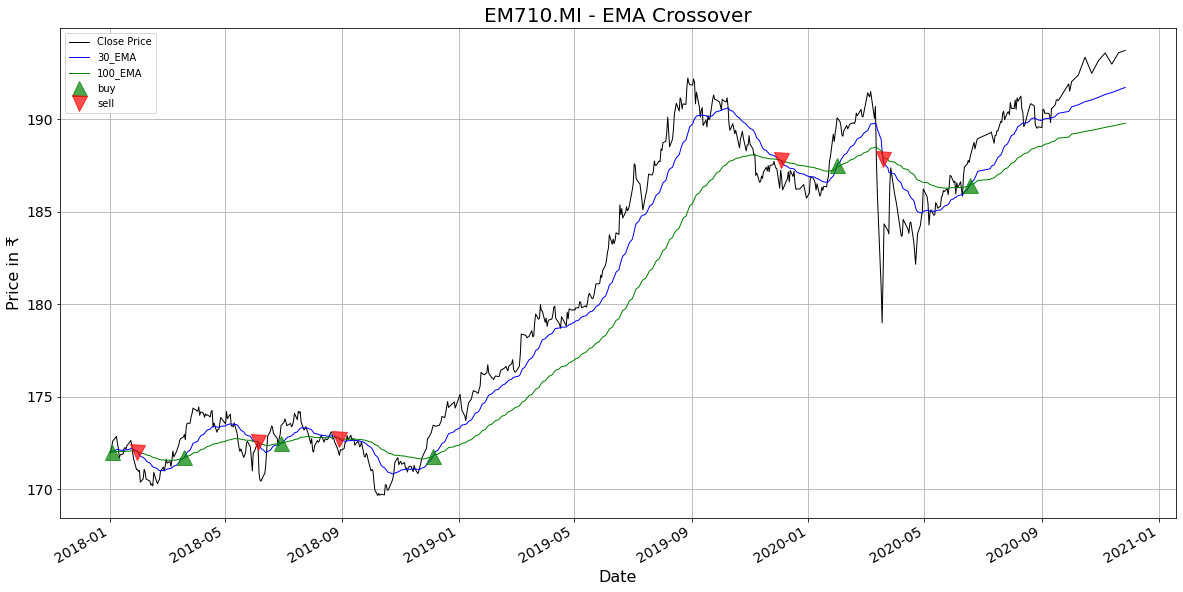

+---------------------+---------------+----------+-----------+----------+------------+
| Date                |   Close Price |   30_EMA |   100_EMA |   Signal | Position   |
|---------------------+---------------+----------+-----------+----------+------------|
| 2018-01-03 00:00:00 |        172.24 |  172.006 |   171.995 |        1 | Buy        |
| 2018-01-30 00:00:00 |        171.06 |  172.017 |   172.029 |        0 | Sell       |
| 2018-03-20 00:00:00 |        172.96 |  171.744 |   171.698 |        1 | Buy        |
| 2018-06-05 00:00:00 |        172.28 |  172.557 |   172.557 |        0 | Sell       |
| 2018-06-29 00:00:00 |        173.44 |  172.507 |   172.479 |        1 | Buy        |
| 2018-08-29 00:00:00 |        171.83 |  172.698 |   172.739 |        0 | Sell       |
| 2018-12-05 00:00:00 |        173.46 |  171.816 |   171.801 |        1 | Buy        |
| 2019-12-03 00:00:00 |        187.25 |  187.771 |   187.782 |        0 | Sell       |
| 2020-01-31 00:00:00 |        190.08 |  18

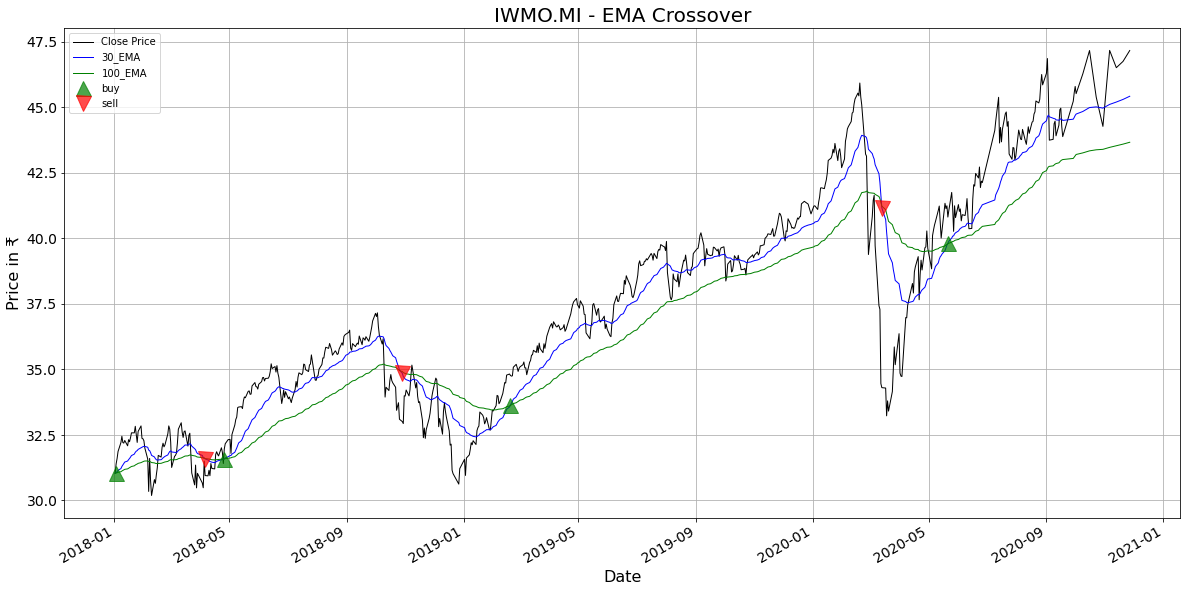

+---------------------+---------------+----------+-----------+----------+------------+
| Date                |   Close Price |   30_EMA |   100_EMA |   Signal | Position   |
|---------------------+---------------+----------+-----------+----------+------------|
| 2018-01-03 00:00:00 |        31.4   |  31.0632 |   31.0471 |        1 | Buy        |
| 2018-04-06 00:00:00 |        30.95  |  31.5863 |   31.5995 |        0 | Sell       |
| 2018-04-26 00:00:00 |        31.965 |  31.5861 |   31.5839 |        1 | Buy        |
| 2018-10-29 00:00:00 |        33.01  |  34.8532 |   34.9193 |        0 | Sell       |
| 2019-02-19 00:00:00 |        34.77  |  33.6439 |   33.627  |        1 | Buy        |
| 2020-03-13 00:00:00 |        34.305 |  41.1644 |   41.233  |        0 | Sell       |
| 2020-05-21 00:00:00 |        40.815 |  39.8104 |   39.7922 |        1 | Buy        |
+---------------------+---------------+----------+-----------+----------+------------+


In [19]:
MovingAverageCrossStrategy(stock_symbol = 'IWDE.MI',start_date = '2018-01-01', end_date = '2020-12-01', short_window = 30, long_window = 100, moving_avg = 'EMA', display_table = True)  
MovingAverageCrossStrategy(stock_symbol = 'EM710.MI',start_date = '2018-01-01', end_date = '2020-12-01', short_window = 30, long_window = 100, moving_avg = 'EMA', display_table = True)
MovingAverageCrossStrategy(stock_symbol = 'IWMO.MI',start_date = '2018-01-01', end_date = '2020-12-01', short_window = 30, long_window = 100, moving_avg = 'EMA', display_table = True)

In [ ]:
0.13**-5

26932.907434290435